In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en
License(s): copyright-authors
100% 985M/987M [00:19<00:00, 56.6MB/s]
100% 987M/987M [00:19<00:00, 53.2MB/s]


In [ ]:
!unzip /content/speech-emotion-recognition-en.zip -d /content/emotion-recognition

Streaming output truncated to the last 5000 lines.
  inflating: /content/emotion-recognition/Crema/1088_IWW_FEA_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_IWW_HAP_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_IWW_NEU_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_IWW_SAD_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_MTI_ANG_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_MTI_DIS_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_MTI_FEA_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_MTI_HAP_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_MTI_NEU_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_MTI_SAD_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_TAI_ANG_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_TAI_DIS_XX.wav  
  inflating: /content/emotion-recognition/Crema/1088_TAI_FEA_XX.wav  
  inflating: /content/emotion-recogniti

In [ ]:
import os

audio_paths = []
labels = []
Dir = "/content/emotion-recognition/Tess/"
for i in os.listdir(Dir):
  for j in os.listdir(Dir+i):
    audio_paths.append(Dir+i+"/"+j)
    labels.append(i)




In [ ]:
import pandas as pd
df = pd.DataFrame({"audio_paths":audio_paths,"labels":labels})
df.head()

,audio_paths,labels
0,/content/emotion-recognition/Tess/YAF_angry/YA...,YAF_angry
1,/content/emotion-recognition/Tess/YAF_angry/YA...,YAF_angry
2,/content/emotion-recognition/Tess/YAF_angry/YA...,YAF_angry
3,/content/emotion-recognition/Tess/YAF_angry/YA...,YAF_angry
4,/content/emotion-recognition/Tess/YAF_angry/YA...,YAF_angry


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   audio_paths  2800 non-null   object
 1   labels       2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


In [ ]:
df["labels"].unique()

array(['YAF_angry', 'OAF_Sad', 'YAF_happy', 'OAF_disgust', 'OAF_neutral',
       'YAF_sad', 'OAF_Fear', 'YAF_fear', 'YAF_disgust',
       'YAF_pleasant_surprised', 'OAF_Pleasant_surprise', 'OAF_angry',
       'OAF_happy', 'YAF_neutral'], dtype=object)

In [ ]:
df["labels"].apply(lambda x: 'pleasant_surprise' if x == 'pleasant_surprised' else x[4:].lower()).unique()

array(['angry', 'sad', 'happy', 'disgust', 'neutral', 'fear',
       'pleasant_surprised', 'pleasant_surprise'], dtype=object)

In [ ]:
df["labels"] = df["labels"].apply(lambda x: 'pleasant_surprise' if x == 'pleasant_surprised' else x[4:].lower())

In [ ]:
df["labels"].replace({'pleasant_surprised':'pleasant_surprise'},inplace=True)

<ipython-input-19-12aaa5d6ad80>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["labels"].replace({'pleasant_surprised':'pleasant_surprise'},inplace=True)


In [ ]:
df["labels"].value_counts()

,count
labels,
angry,400
sad,400
happy,400
disgust,400
neutral,400
fear,400
pleasant_surprise,400


In [ ]:
map = {
    "fear":"negative",
    "angry":"negative",
    "disgust":"negative",
    "sad":"negative",
    "pleasant_surprise":"positive",
    "happy":"positive"
}

In [ ]:
df["labels"].replace(map,inplace=True)

In [ ]:
df["labels"].value_counts()

,count
labels,
negative,1600
positive,800
neutral,400


In [ ]:
import librosa
import numpy as np
import os

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)

    # 1. MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # 2. Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # 3. Spectral Features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # 4. RMS Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # 5. Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # 6. Fundamental Frequency (Pitch)
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_mean = np.nanmean(f0) if np.any(np.isfinite(f0)) else 0

    # Combine all features into a single array
    features = np.hstack([mfcc_mean, chroma_mean, spectral_centroid, spectral_bandwidth, spectral_flatness, spectral_rolloff, rms, zcr, f0_mean])
    return features

In [ ]:
from tqdm import tqdm
audio_features = []
for i in tqdm(range(len(df))):
  audio_features.append(extract_features(df["audio_paths"].values[i]))

100%|██████████| 2800/2800 [24:07<00:00,  1.93it/s]


In [ ]:
audio_features = np.array(audio_features)

In [ ]:
audio_features.shape

(2800, 32)

In [ ]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration
model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of Speech2TextForConditionalGeneration were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/235k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/417k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
import librosa

y,sr = librosa.load(df["audio_paths"].values[0],sr=16000)
inputs = processor(y, sampling_rate=sr, return_tensors="pt")
inputs

{'input_features': tensor([[[-1.2326, -1.1997, -1.3836,  ...,  0.0583, -0.1851, -0.2734],
         [-0.8934, -0.2713,  0.0289,  ...,  0.7134,  0.4329, -0.0999],
         [-1.8770, -0.3229,  0.6179,  ...,  1.3635,  1.0004,  0.8085],
         ...,
         [-0.3588,  0.3905, -1.4670,  ..., -1.6557, -1.3640, -1.0880],
         [-0.2876, -0.5892, -0.7724,  ..., -1.1033, -1.1545, -1.0165],
         [-1.1261, -1.1881, -1.4013,  ..., -1.1338, -0.9026, -1.2632]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
generated_ids = model.generate(inputs["input_features"], attention_mask=inputs["attention_mask"])
transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
transcription

['say the word bone']

In [ ]:
from IPython.display import Audio,Video

In [ ]:
Audio(y,rate=sr)

In [ ]:
def text_generation(audio_path):
  y,sr = librosa.load(audio_path,sr=16000)
  inputs = processor(y, sampling_rate=sr, return_tensors="pt")
  generated_ids = model.generate(inputs["input_features"], attention_mask=inputs["attention_mask"])
  transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
  return transcription[0]

In [ ]:
text_data = []

for i in tqdm(df["audio_paths"].values):
  text_data.append(text_generation(i))

100%|██████████| 2800/2800 [07:14<00:00,  6.44it/s]


In [ ]:
df["Sentences"] = text_data
df.head()

,audio_paths,labels,Sentences
0,/content/emotion-recognition/Tess/YAF_angry/YA...,negative,say the word bone
1,/content/emotion-recognition/Tess/YAF_angry/YA...,negative,say the word youth
2,/content/emotion-recognition/Tess/YAF_angry/YA...,negative,say the word bite
3,/content/emotion-recognition/Tess/YAF_angry/YA...,negative,say the word book
4,/content/emotion-recognition/Tess/YAF_angry/YA...,negative,say the word voice


In [ ]:
text_data = df["Sentences"].tolist()

In [ ]:
from tensorflow.keras import layers


text_vectorizer = layers.TextVectorization(
    max_tokens=512,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=128
)

text_vectorizer.adapt(text_data)

In [ ]:
word_index = len(text_vectorizer.get_vocabulary())+1

In [ ]:
text_features = text_vectorizer(text_data).numpy()
text_features.shape

(2800, 128)

In [ ]:
id2label = {}
label2id = {}
for index,i in enumerate(df["labels"].unique()):
  id2label[index] = i
  label2id[i] = index

In [ ]:
labels = df["labels"].apply(lambda x:label2id[x]).values

In [ ]:
from sklearn.model_selection import train_test_split

X_train_audio,X_test_audio,X_train_text,X_test_text,y_train,y_test = train_test_split(
    audio_features,text_features,
    labels,
    test_size=.2,
    random_state=42,
    shuffle=True,
    stratify=labels
)

In [ ]:
import numpy as np
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SVMSMOTE

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

smote = BorderlineSMOTE(random_state=42)
tomek = SMOTEENN(random_state=42)
pipeline = Pipeline(steps=[('smote', smote), ('tomek', tomek)])

X_combined = np.hstack([X_train_audio, X_train_text])

X_resampled, y_resampled = pipeline.fit_resample(X_combined, y_train)



# sm = BorderlineSMOTE()


# X_combined = np.hstack([X_train_audio, X_train_text])


# X_resampled, y_resampled = sm.fit_resample(X_combined, y_train)

# smotenn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smotenn.fit_resample(X_resampled, y_resampled)

In [ ]:

# After SMOTE, split the resampled data back into audio and text features
num_audio_features = X_train_audio.shape[1]
X_train_audio_resampled = X_resampled[:, :num_audio_features]
X_train_text_resampled = X_resampled[:, num_audio_features:]

In [ ]:
y_train = y_resampled

In [ ]:
X_train_audio_resampled.shape,X_test_audio.shape,X_train_text_resampled.shape,X_test_text.shape,y_train.shape,y_test.shape

((2803, 32), (560, 32), (2803, 128), (560, 128), (2803,), (560,))

In [ ]:
pd.DataFrame(y_train).value_counts()

,count
0,
2,1187
1,1085
0,531


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(X_train_audio, X_train_text, word_index):
    # Audio Model with Transformer
    audio_inputs = layers.Input(shape=(X_train_audio_resampled.shape[1],))
    x = layers.Reshape((-1, 1))(audio_inputs)  # Reshape for 1D convolutions
    x = layers.Conv1D(64, 5, activation="relu")(x)  # Convolution layer
    x = layers.MaxPooling1D()(x)  # Max pooling
    x = layers.Conv1D(128, 3, activation="relu")(x)
    x = layers.MaxPooling1D()(x)

    # Transformer Block for Audio
    audio_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    audio_transformer = layers.Dropout(0.2)(audio_transformer)
    audio_transformer = layers.LayerNormalization()(audio_transformer)
    x = layers.Add()([x, audio_transformer])  # Skip connection
    x = layers.GlobalAveragePooling1D()(x)  # Pool after Transformer #Now should work since x is 3D

    # Text Model with Transformer
    text_inputs = layers.Input(shape=(X_train_text.shape[1],))
    y = layers.Embedding(input_dim=word_index, output_dim=128)(text_inputs)
    y = layers.LSTM(128, return_sequences=True)(y)

    # Transformer Block for Text
    text_transformer = layers.MultiHeadAttention(num_heads=4, key_dim=128)(y, y)
    text_transformer = layers.Dropout(0.2)(text_transformer)
    text_transformer = layers.LayerNormalization()(text_transformer)
    y = layers.Add()([y, text_transformer])  # Skip connection
    y = layers.GlobalAveragePooling1D()(y)  # Pool after Transformer

    # Concatenate Audio and Text Features
    z = layers.Concatenate()([x, y])
    z = layers.Dense(256, activation="relu")(z)
    z = layers.Dropout(0.25)(z)

    # Output Layer
    outputs = layers.Dense(3, activation="softmax")(z)

    # Compile the Model
    model = models.Model(inputs=[audio_inputs, text_inputs], outputs=outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
model = create_model(X_train_audio_resampled, X_train_text_resampled, word_index)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 32, 1)          │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 28, 64)         │            384 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 14, 64)         │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 12, 128)        │         24,704 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 128, 128)       │         52,864 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 6, 128)         │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ (None, 128, 128)       │        131,584 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 6, 128)         │        263,808 │ max_pooling1d_3[0][0], │
│ (MultiHeadAttention)      │                        │                │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 128, 128)       │        263,808 │ lstm_12[0][0],         │
│ (MultiHeadAttention)      │                        │                │ lstm_12[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 6, 128)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128)       │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 6, 128)         │            256 │ dropout_7[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 128, 128)       │            256 │ dropout_9[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)            

 Total params: 804,227 (3.07 MB)

 Trainable params: 804,227 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

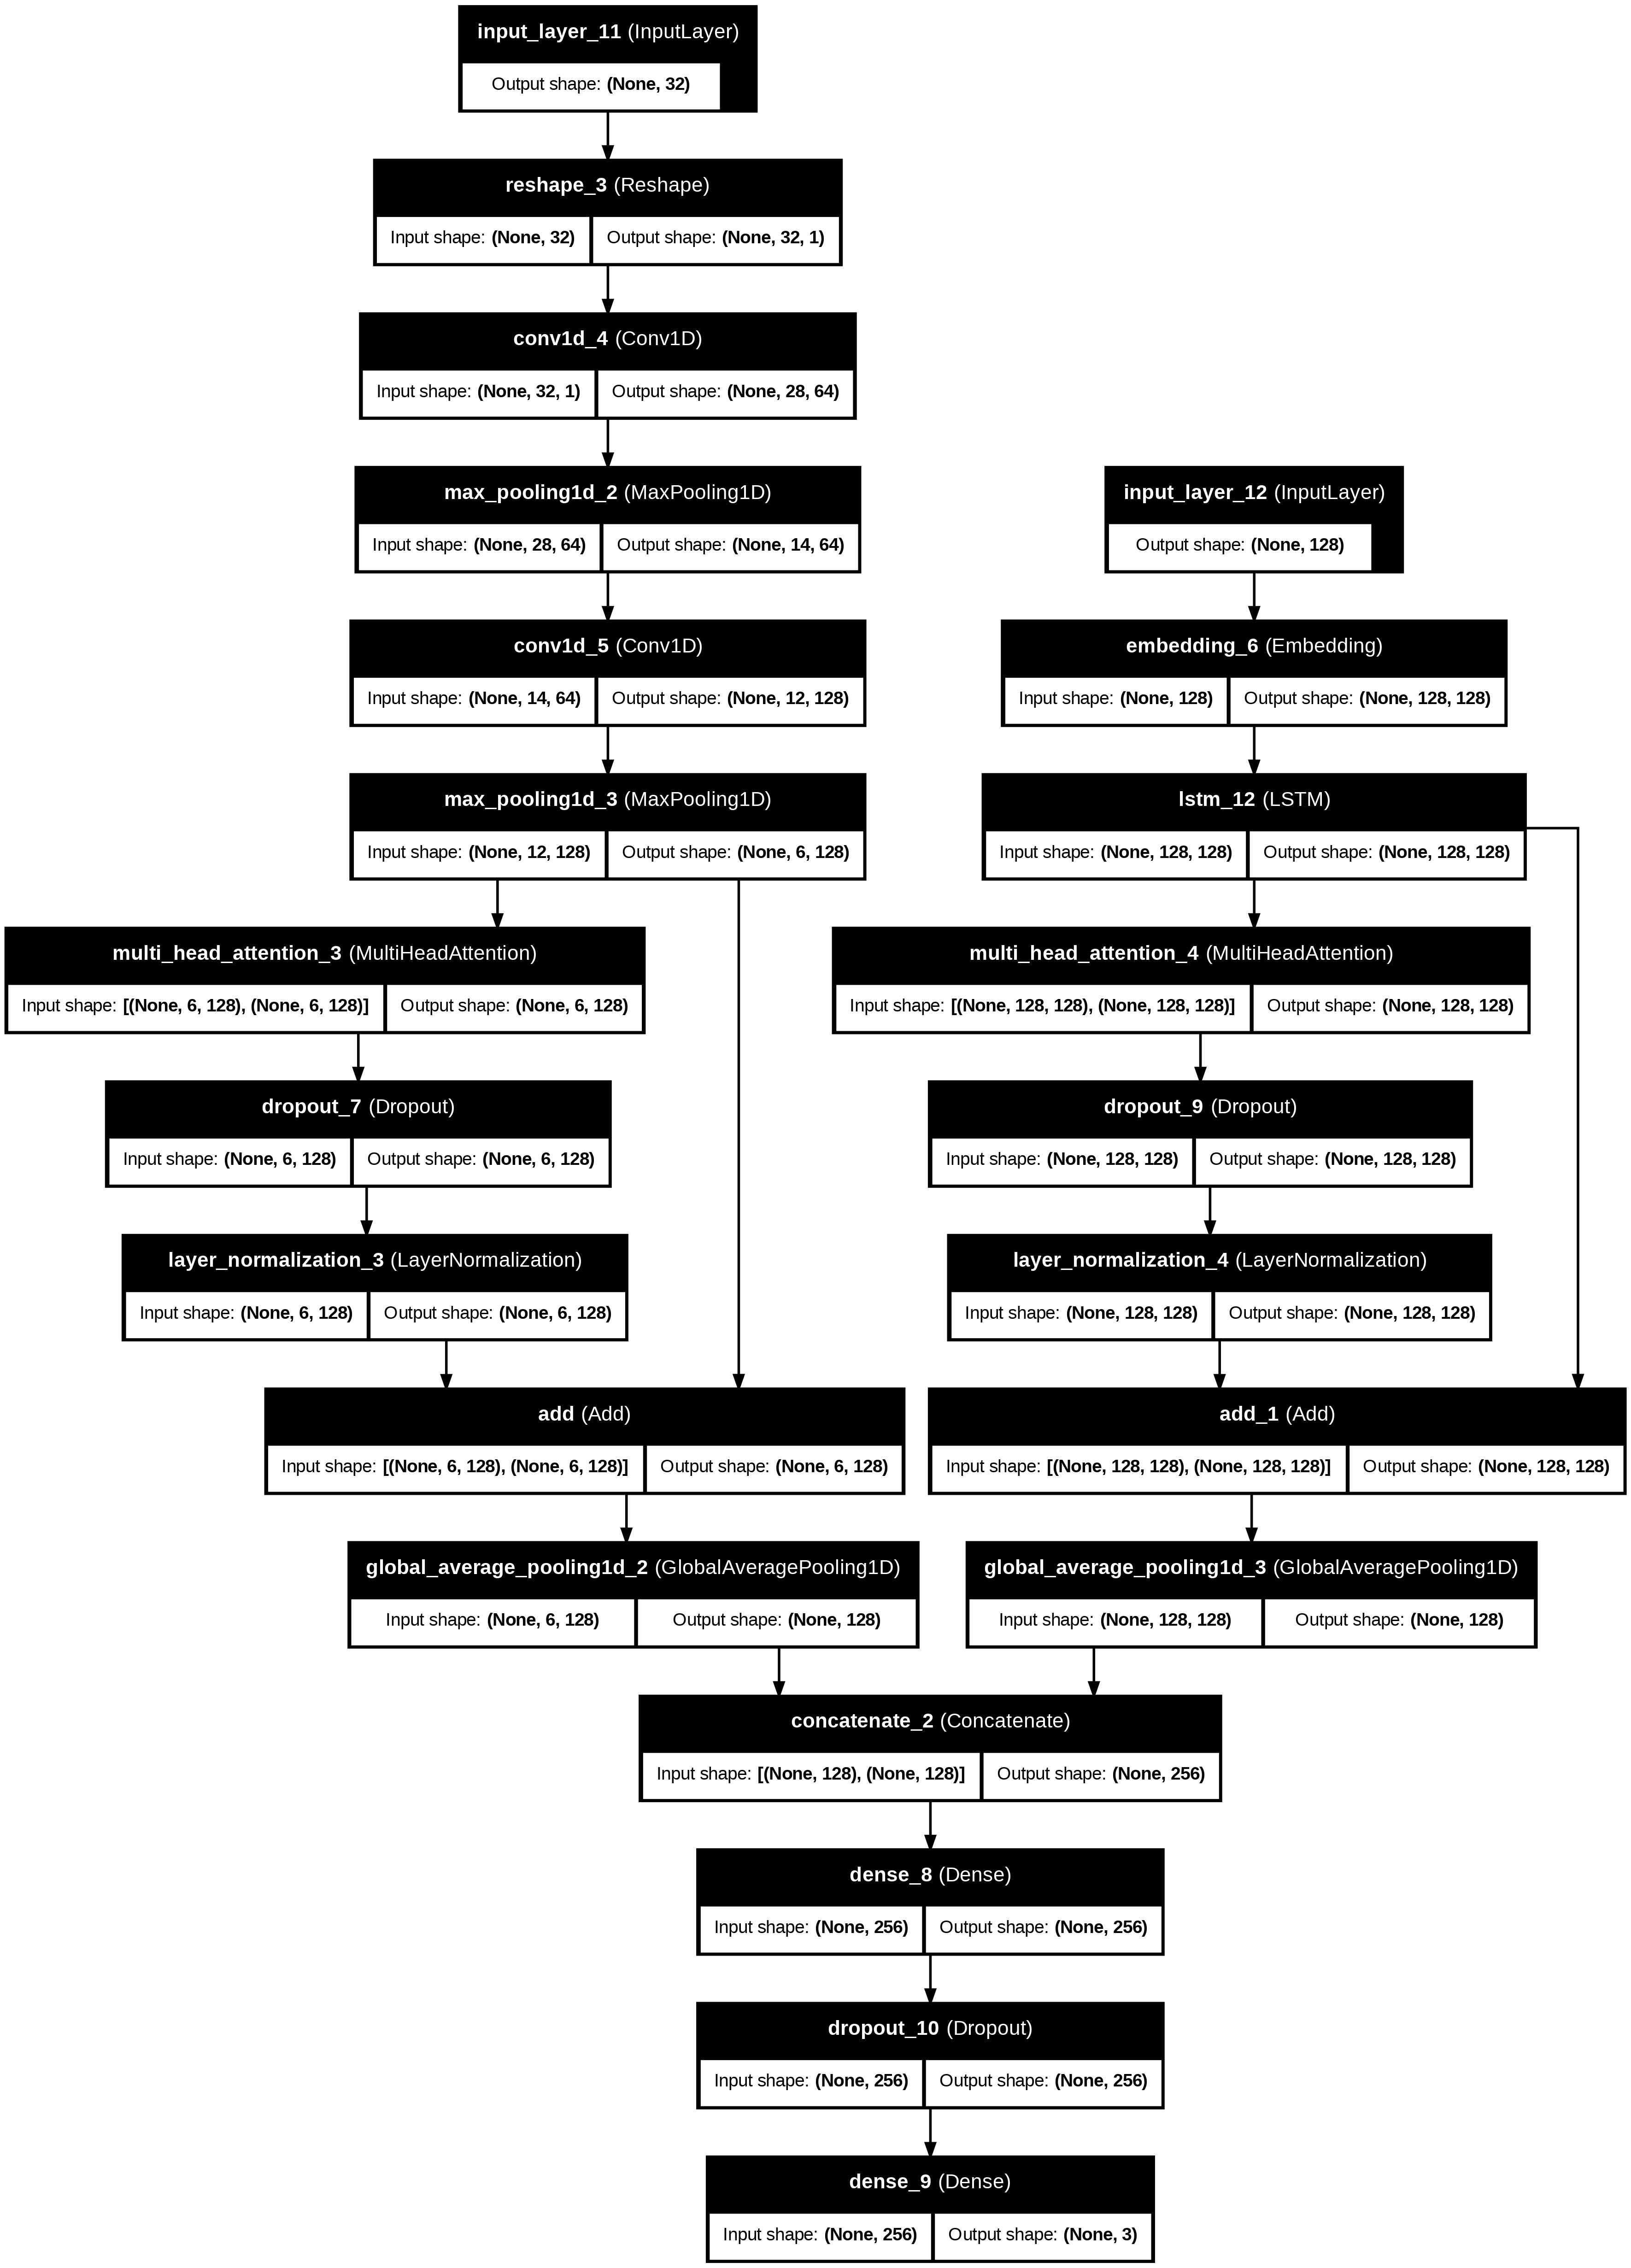

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
X_train_audio_resampled.shape,X_train_text_resampled.shape,y_resampled.shape,X_test_audio.shape,X_test_text.shape,y_test.shape

((2803, 32), (2803, 128), (2803,), (560, 32), (560, 128), (560,))

In [ ]:
callback_list = [
    tf.keras.callbacks.ModelCheckpoint(
        "model.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=100,
        restore_best_weights=True,
    )
]

In [ ]:
history = model.fit(
    [X_train_audio_resampled,X_train_text_resampled],y_train,epochs=100,
    validation_data=([X_test_audio,X_test_text],y_test),
    callbacks=callback_list
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.4202 - loss: 8.7512 - val_accuracy: 0.4214 - val_loss: 1.0787
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7552 - loss: 0.6296 - val_accuracy: 0.4250 - val_loss: 1.1082
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7904 - loss: 0.5110 - val_accuracy: 0.5875 - val_loss: 0.8765
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8124 - loss: 0.4655 - val_accuracy: 0.5250 - val_loss: 1.0159
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7939 - loss: 0.4725 - val_accuracy: 0.5679 - val_loss: 0.8090
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8316 - loss: 0.4183 - val_accuracy: 0.6393 - val_loss: 0.8323
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8465 - loss: 0.3675 - val_accuracy: 0.5911 - val_loss: 0.9698
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8682 - loss: 0.3425 - val_accuracy: 0

In [ ]:
model.evaluate([X_test_audio,X_test_text],y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9555 - loss: 0.1717


[0.11660802364349365, 0.9642857313156128]

In [ ]:
y_pred = model.predict([X_test_audio,X_test_text])
y_pred

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([[9.9999559e-01, 8.5061436e-07, 3.6214792e-06],
       [9.8739362e-01, 1.2606394e-02, 6.9253248e-09],
       [9.9971074e-01, 2.8918375e-04, 4.1666216e-15],
       ...,
       [1.0072846e-05, 7.2687301e-10, 9.9998987e-01],
       [9.9977416e-01, 2.2585868e-04, 1.5669248e-15],
       [9.9999928e-01, 7.0167010e-07, 9.8262671e-17]], dtype=float32)

In [ ]:
prediction = []
for pred in y_pred:
  prediction.append(np.argmax(pred))

In [ ]:
from sklearn.metrics import classification_report


print("Classification_Report : \n",
      classification_report(prediction,y_test))

Classification_Report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       314
           1       0.97      0.96      0.96       162
           2       0.97      0.93      0.95        84

    accuracy                           0.96       560
   macro avg       0.97      0.95      0.96       560
weighted avg       0.96      0.96      0.96       560



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(prediction,y_test)

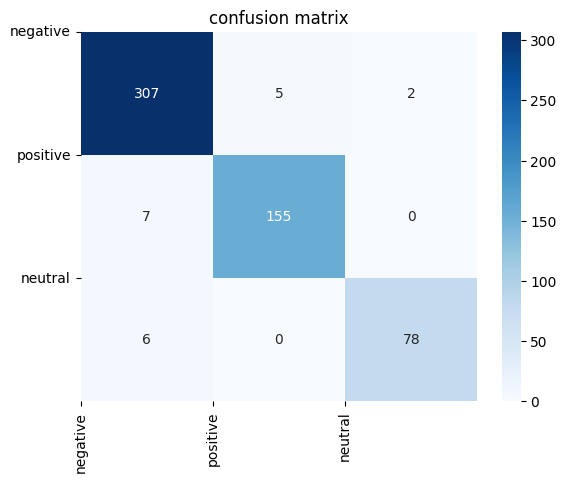

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xticks(ticks = range(len(df["labels"].unique())),labels = df["labels"].unique(),rotation=90)
plt.yticks(ticks = range(len(df["labels"].unique())),labels = df["labels"].unique(),rotation=0)
plt.title("confusion matrix")
plt.show()

In [ ]:
model.save("model.keras")

In [ ]:
pd.concat([pd.DataFrame(y_test,columns=["Actual"]),pd.DataFrame(prediction,columns=["Prediction"])],axis=1).to_csv("Prediction_Actual.csv",index=False)

In [ ]:
history = {"loss":history.history["loss"],
 "val_loss":history.history["val_loss"],
 "accuracy":history.history["accuracy"],
 "val_accuracy":history.history["val_accuracy"]}

In [ ]:
import json

with open("histories.json","w") as f:
  json.dump(history,f)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, LSTM, MultiHeadAttention,
                                     LayerNormalization, Dense, Dropout, GlobalAveragePooling1D,
                                     Concatenate, Add, Multiply, Reshape)
from tensorflow.keras.models import Model

class SplitLayer(layers.Layer):
    def __init__(self, num_or_size_splits, axis=-1, **kwargs):
        super(SplitLayer, self).__init__(**kwargs)
        self.num_or_size_splits = num_or_size_splits
        self.axis = axis

    def call(self, inputs):
        return tf.split(inputs, num_or_size_splits=self.num_or_size_splits, axis=self.axis)

def self_modulating_fusionformer(input_shape_cnn=(X_train_audio_resampled.shape[1],), input_shape_lstm=(X_train_text_resampled.shape[1],)):
    # CNN Branch
    cnn_input = Input(shape=input_shape_cnn)
    x = Reshape((-1, 1))(cnn_input)
    x = Conv1D(64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    transformer_features = x
    cnn_features = GlobalAveragePooling1D()(x)

    # LSTM Branch
    lstm_input = Input(shape=input_shape_lstm)
    # Reshape LSTM input to 3D: (batch_size, timesteps, features)
    # Assuming input_shape_lstm=(128,) represents 128 features and 1 timestep
    lstm_input_reshaped = Reshape((-1,1))(lstm_input)
    x = LSTM(128, return_sequences=True)(lstm_input_reshaped) # Set return_sequences=True for 3D output
    x = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = LayerNormalization()(x)
    lstm_features = GlobalAveragePooling1D()(x)

    x = MultiHeadAttention(num_heads=4, key_dim=128)(transformer_features, transformer_features)
    x = LayerNormalization()(x)
    transformer_features = GlobalAveragePooling1D()(x)

    # Self-Modulating Fusion Mechanism
    fusion_weights = Dense(3, activation='softmax')(Concatenate()([cnn_features, lstm_features, transformer_features]))

    # Use the custom SplitLayer instead of tf.split
    cnn_weight, lstm_weight, transformer_weight = SplitLayer(num_or_size_splits=3, axis=-1)(fusion_weights)

    fused_features = Add()([
        Multiply()([cnn_features, cnn_weight]),
        Multiply()([lstm_features, lstm_weight]),
        Multiply()([transformer_features, transformer_weight])
    ])

    # Classification Head
    x = Dense(256, activation='relu')(fused_features)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax')(x)

    # Define Model
    model = Model(inputs=[cnn_input, lstm_input], outputs=output)
    return model

# Create Model
model = self_modulating_fusionformer()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 32, 1)          │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 28, 64)         │            384 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 14, 64)         │              0 │ conv1d_6[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 12, 128)        │         24,704 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 128, 1)         │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 6, 128)         │              0 │ conv1d_7[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ (None, 128, 128)       │         66,560 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 128, 128)       │        263,808 │ lstm_13[0][0],         │
│ (MultiHeadAttention)      │                        │                │ lstm_13[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_6    │ (None, 6, 128)         │        263,808 │ max_pooling1d_5[0][0], │
│ (MultiHeadAttention)      │                        │                │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 128, 128)       │            256 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 6, 128)         │            256 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ max_pooling1d_5[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ layer_normalization_5… │
│ (GlobalAveragePooling

 Total params: 654,726 (2.50 MB)

 Trainable params: 654,726 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

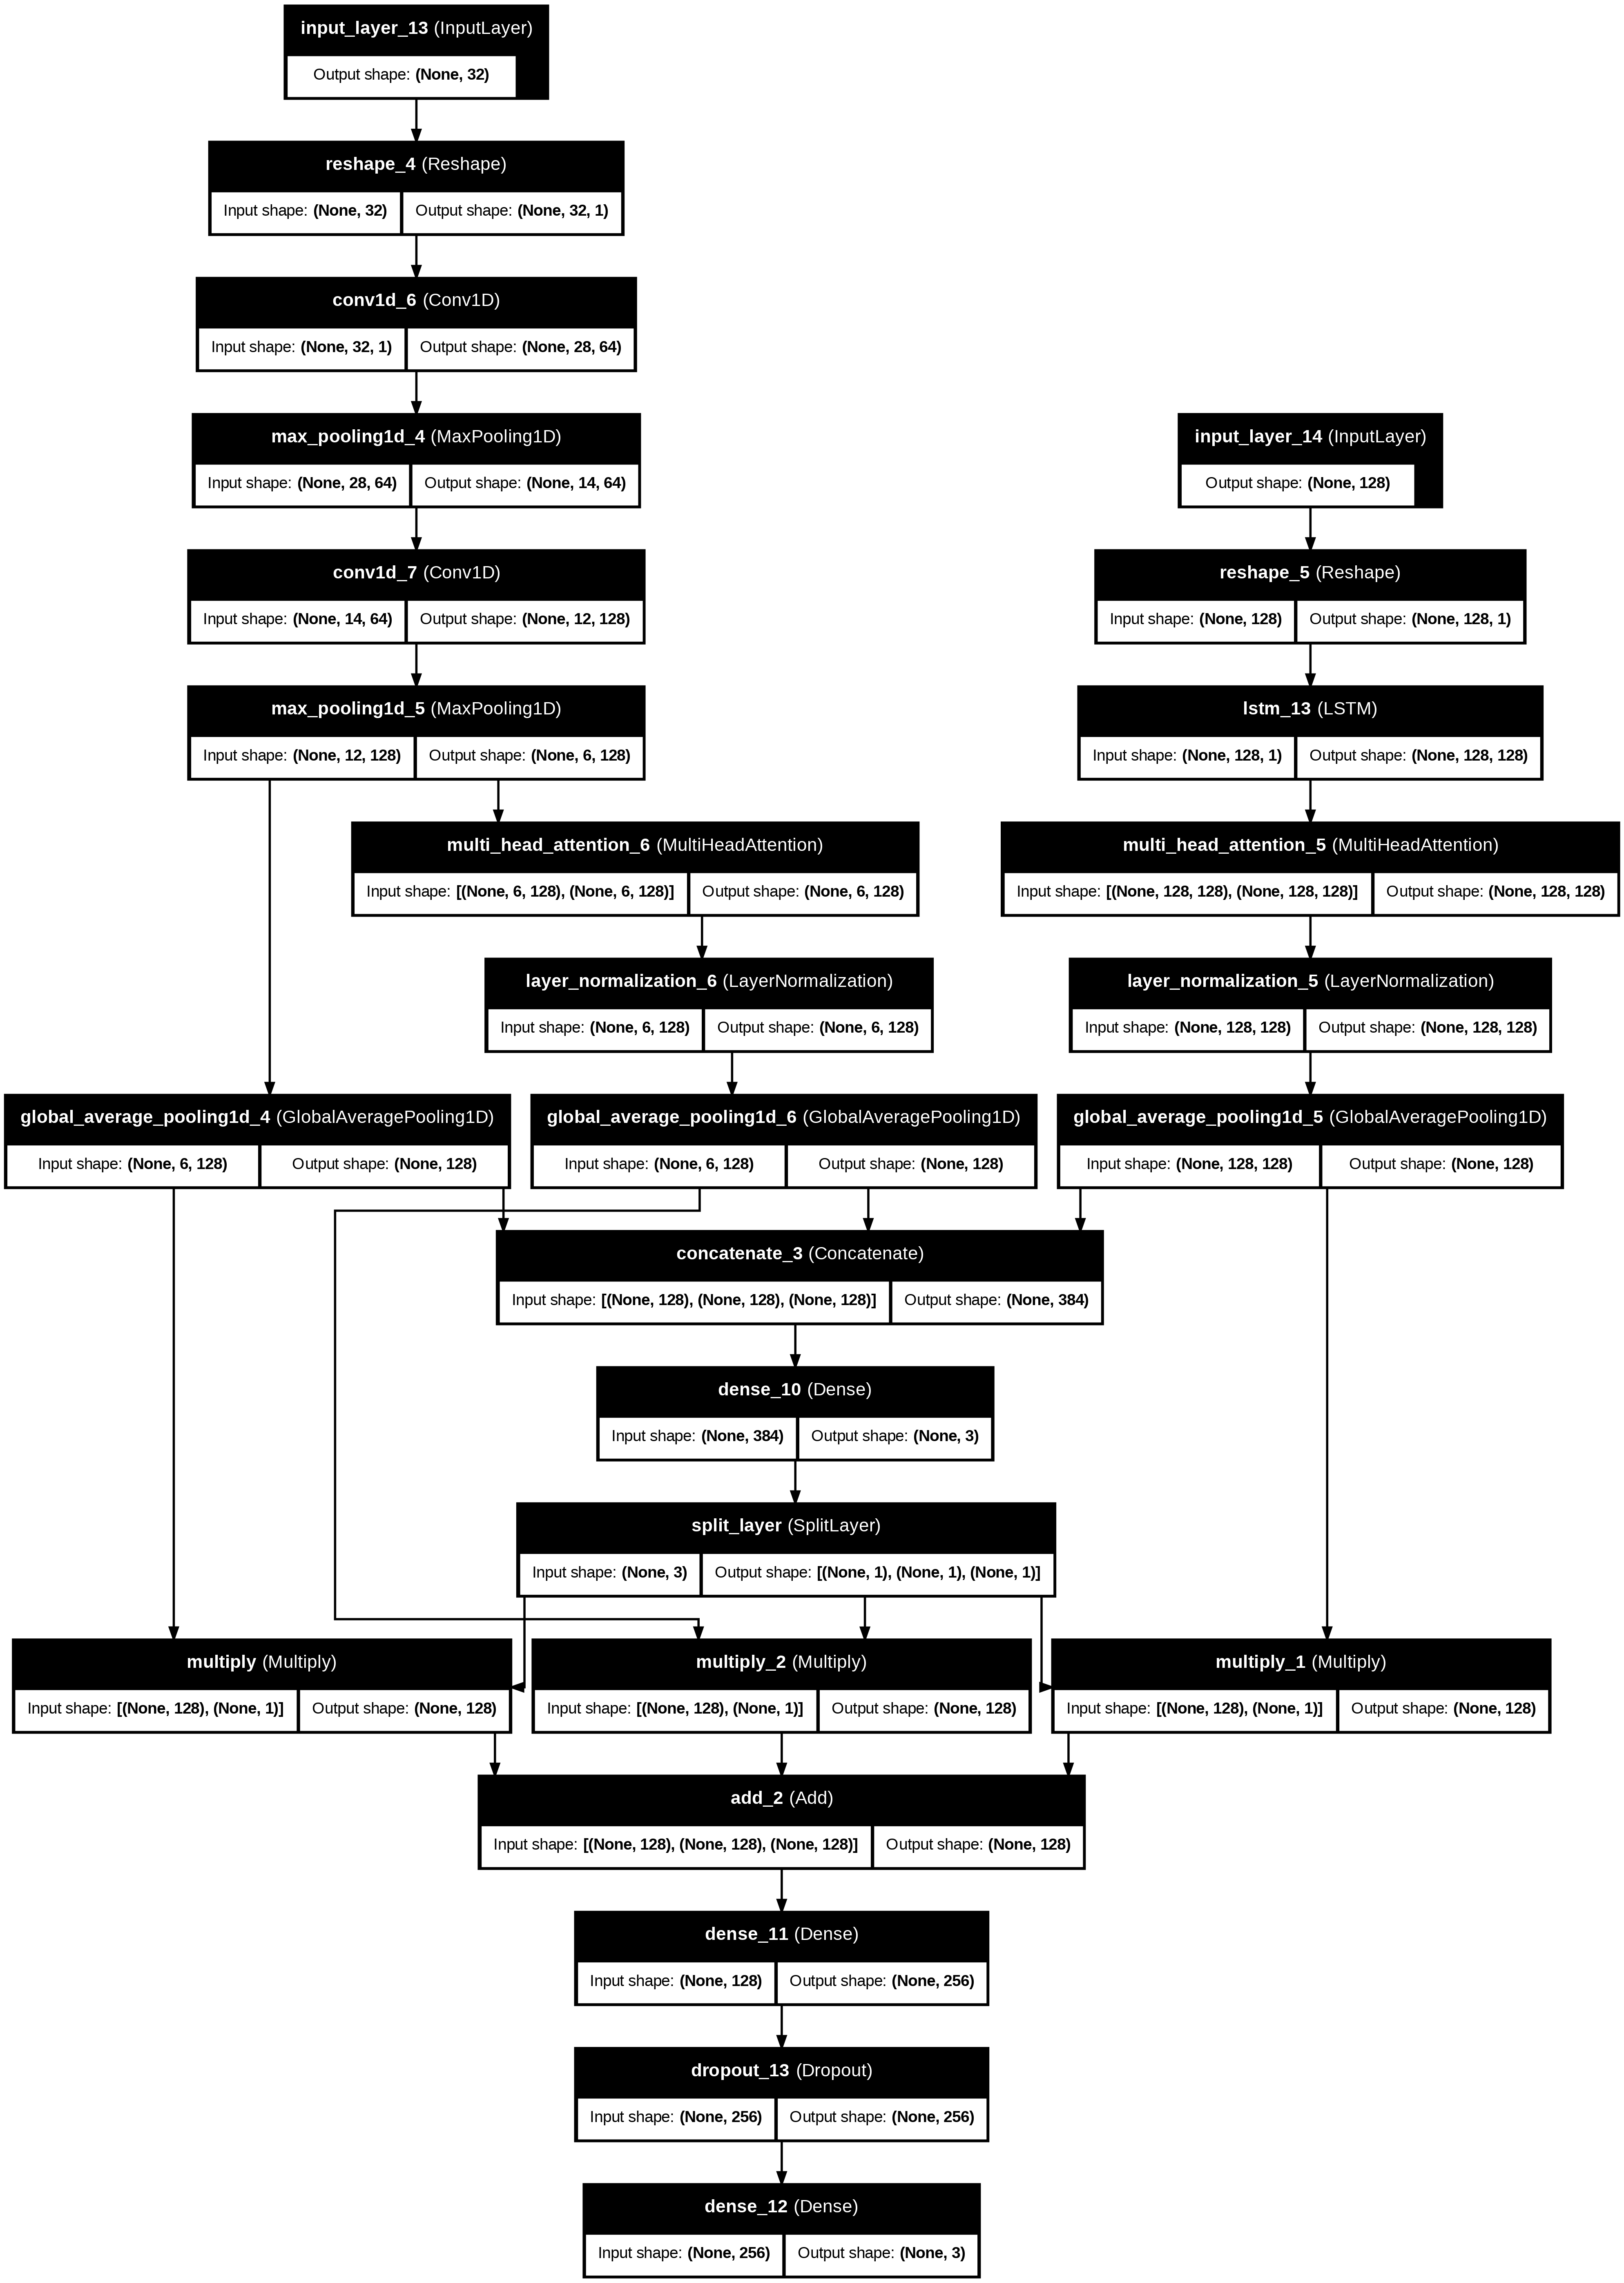

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True,to_file="model_new.png")

In [ ]:
history = model.fit(
    [X_train_audio_resampled,X_train_text_resampled],y_train,epochs=200,
    validation_data=([X_test_audio,X_test_text],y_test),
    callbacks=callback_list
)

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3883 - loss: 1.2306 - val_accuracy: 0.1589 - val_loss: 1.3707
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6738 - loss: 0.8049 - val_accuracy: 0.4411 - val_loss: 1.0360
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7828 - loss: 0.5416 - val_accuracy: 0.4054 - val_loss: 1.2459
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7997 - loss: 0.5328 - val_accuracy: 0.6393 - val_loss: 0.8011
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8150 - loss: 0.4708 - val_accuracy: 0.5929 - val_loss: 0.9518
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8575 - loss: 0.3889 - val_accuracy: 0.6500 - val_loss: 0.8350
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8844 - loss: 0.3007 - val_accuracy: 0.6286 - val_loss: 0.9599
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8561 - loss: 0.3896 - val_accuracy: 0.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, LSTM, MultiHeadAttention,
                                     LayerNormalization, Dense, Dropout, GlobalAveragePooling1D,
                                     Concatenate, Add, Multiply, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable() # Register the custom layer
class SplitLayer(layers.Layer):
    def __init__(self, num_or_size_splits, axis=-1, **kwargs):
        super(SplitLayer, self).__init__(**kwargs)
        self.num_or_size_splits = num_or_size_splits
        self.axis = axis

    def call(self, inputs):
        return tf.split(inputs, num_or_size_splits=self.num_or_size_splits, axis=self.axis)

    def get_config(self):  # Add get_config method for serialization
        config = super().get_config()
        config.update({
            "num_or_size_splits": self.num_or_size_splits,
            "axis": self.axis,
        })
        return config

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("model.keras", custom_objects={"SplitLayer": SplitLayer})

In [ ]:
model.evaluate(
    [X_test_audio,X_test_text],y_test
)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9868 - loss: 0.0580


[0.043981119990348816, 0.987500011920929]

In [ ]:
y_pred = model.predict(
    [X_test_audio,X_test_text]
)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [ ]:
from sklearn.metrics import classification_report


print("Classification_Report : \n",
      classification_report(np.argmax(y_pred,axis=1),y_test))

Classification_Report : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       317
           1       0.99      0.97      0.98       163
           2       1.00      1.00      1.00        80

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(
    np.argmax(y_pred,axis=1),y_test
)

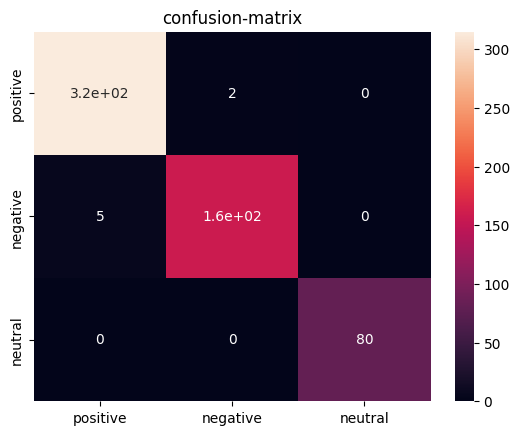

In [ ]:
sns.heatmap(cm,annot=True)
plt.title("confusion-matrix")
plt.xticks([0.5,1.5,2.5],["positive","negative","neutral"])
plt.yticks([0.5,1.5,2.5],["positive","negative","neutral"])
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

import tensorflow as tf
from tensorflow.keras import layers, models

# Function to create the audio model (using CNN for feature extraction)
def create_audio_model(input_shape):
    audio_input = layers.Input(shape=input_shape)  # Define input layer
    x = layers.Reshape((-1,1))(audio_input)
    x = layers.Conv1D(64, 3, activation='relu') (x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    audio_output = layers.Dense(64, activation='relu')(x) # Define output layer
    audio_model = models.Model(inputs=audio_input, outputs=audio_output)  # Create Model instance
    return audio_model

# Function to create the text model (using LSTM for sequence processing)
def create_text_model(input_shape):
    text_input = layers.Input(shape=input_shape)  # Define input layer
    x = layers.Embedding(input_dim=10000, output_dim=128, input_length=input_shape[0])(text_input)  # Assume vocab size of 10k
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128)(x)
    text_output = layers.Dense(64, activation='relu')(x)  # Define output layer
    text_model = models.Model(inputs=text_input, outputs=text_output) # Create Model instance
    return text_model

# Function for dynamic attention fusion layer
class DynamicAttentionFusion(layers.Layer):
    def __init__(self, output_dim):
        super(DynamicAttentionFusion, self).__init__()
        self.attention_audio = layers.Dense(output_dim, activation='sigmoid')
        self.attention_text = layers.Dense(output_dim, activation='sigmoid')
        self.output_layer = layers.Dense(output_dim)

    def call(self, audio_features, text_features):
        audio_attention = self.attention_audio(audio_features)
        text_attention = self.attention_text(text_features)
        fused_features = audio_attention * audio_features + text_attention * text_features
        return self.output_layer(fused_features)

# Function for cross-attention between audio and text
class CrossAttention(layers.Layer):
    def __init__(self, output_dim):
        super(CrossAttention, self).__init__()
        self.q = layers.Dense(output_dim)
        self.k = layers.Dense(output_dim)
        self.v = layers.Dense(output_dim)
        self.output_layer = layers.Dense(output_dim)

    def call(self, audio_features, text_features):
        query = self.q(audio_features)
        key = self.k(text_features)
        value = self.v(text_features)

        attention_scores = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(tf.cast(tf.shape(audio_features)[-1], tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attended_output = tf.matmul(attention_weights, value)
        return self.output_layer(attended_output)

# Function for dynamic attention fusion layer
class DynamicAttentionFusion(layers.Layer):
    def __init__(self, output_dim):
        super(DynamicAttentionFusion, self).__init__()
        self.attention_audio = layers.Dense(output_dim, activation='sigmoid')
        self.attention_text = layers.Dense(output_dim, activation='sigmoid')
        self.output_layer = layers.Dense(output_dim)

    def call(self, audio_features, text_features):
        audio_attention = self.attention_audio(audio_features)
        text_attention = self.attention_text(text_features)
        fused_features = audio_attention * audio_features + text_attention * text_features
        return self.output_layer(fused_features)

# Function to create the multi-task model for audio-text fusion classification
def create_multimodal_model(audio_input_shape, text_input_shape, num_classes=10, output_dim=64):
    audio_model = create_audio_model(audio_input_shape)
    text_model = create_text_model(text_input_shape)

    fusion_block = DynamicAttentionFusion(output_dim)

    # Fusion of both modalities
    fused_features = fusion_block(audio_model.output, text_model.output)

    # Final classification layer
    classification_output = layers.Dense(num_classes, activation='softmax')(fused_features)

    # Define the model
    model = models.Model(inputs=[audio_model.input, text_model.input], outputs=classification_output)
    return model

# Function to compile the multimodal classification model
def compile_multimodal_model(audio_input_shape, text_input_shape, num_classes=3, output_dim=64):
    model = create_multimodal_model(audio_input_shape, text_input_shape, num_classes, output_dim)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Example Usage
audio_input_shape = (32,)
text_input_shape = (128,)

# Instantiate and compile the model
model = compile_multimodal_model(audio_input_shape, text_input_shape, output_dim=64)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 32, 1)          │              0 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 30, 64)         │            256 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 15, 64)         │              0 │ conv1d_8[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 13, 128)        │         24,704 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_16            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 6, 128)         │              0 │ conv1d_9[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 128, 128)       │      1,280,000 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 768)            │              0 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 128, 128)       │        131,584 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 256)            │        196,864 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ (None, 128)            │        131,584 │ lstm_14[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │         16,448 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │          8,256 │ lstm_15[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dynamic_attention_fusion  │ (None, 64)             │         12,480 │ dense_14[0][0],        │
│ (DynamicAttentionFusion)  │                        │                │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 3)              │            195 │ dynamic_attention_fus… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,802,371 (6.88 MB)

 Trainable params: 1,802,371 (6.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_train_audio_resampled,X_train_text_resampled],y_train,epochs=200,
    validation_data=([X_test_audio,X_test_text],y_test),
    callbacks=callback_list
)

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3610 - loss: 36.2192 - val_accuracy: 0.3321 - val_loss: 9.0616
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6714 - loss: 2.4350 - val_accuracy: 0.6518 - val_loss: 1.1965
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7278 - loss: 2.1332 - val_accuracy: 0.6107 - val_loss: 2.3151
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6690 - loss: 2.2580 - val_accuracy: 0.7714 - val_loss: 0.8007
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8692 - loss: 0.4726 - val_accuracy: 0.7232 - val_loss: 1.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8240 - loss: 0.7670 - val_accuracy: 0.7821 - val_loss: 0.7918
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7818 - loss: 1.2492 - val_accuracy: 0.5607 - val_loss: 2.8858
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8546 - loss: 0.6740 - val_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report


print("Classification_Report : \n",
      classification_report(np.argmax(y_pred,axis=1),y_test))

Classification_Report : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       317
           1       0.99      0.97      0.98       163
           2       1.00      1.00      1.00        80

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560

